Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteE00VVO/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Epoch 1/30
582/582 [==============================] - 131s 177ms/step - loss: 4.6340 - accuracy: 0.9305 - val_loss: 2.5488 - val_accuracy: 0.9310
Epoch 2/30
582/582 [==============================] - 98s 168ms/step - loss: 1.3647 - accuracy: 0.9742 - val_loss: 0.8003 - val_accuracy: 0.9512
Epoch 3/30
582/582 [==============================] - 93s 159ms/step - loss: 0.3863 - accuracy: 0.9816 - val_loss: 0.2640 - val_accuracy: 0.9650
Epoch 4/30
582/582 [==============================] - 92s 158ms/step - loss: 0.1228 - accuracy: 0.9858 - val_loss: 0.2619 - val_accuracy: 0.9435
Epoch 5/30
582/582 [==============================] - 99s 169ms/step - loss: 0.0552 - accuracy: 0.9893 - val_loss: 0.1085 - val_accuracy: 0.9675
Epoch 6/30
582/582 [==============================] - 93s 159ms/step - loss: 0.0360 - accuracy: 0.9911 - val_loss: 0.1677 - val_accuracy: 0.9

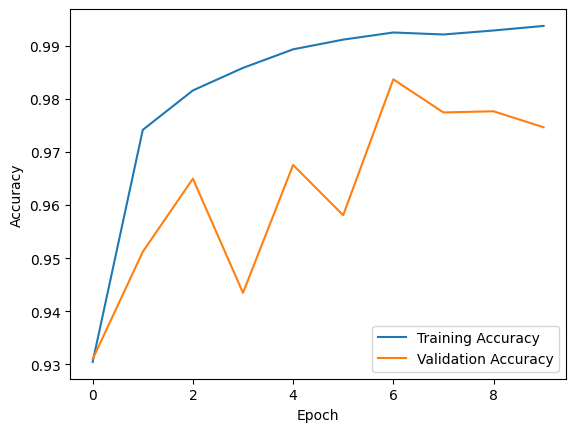

In [ ]:

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
(train_ds, test_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
    image = preprocess_input(image)
    return image, label
train_ds = train_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)
batch_size = 32
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_ds, epochs=20, validation_data=test_ds, callbacks=[early_stopping])
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
def display_images_with_predictions(model, dataset, num_images=5):
    for images, labels in dataset.take(num_images):
        reversed_images = (images + 1.0) / 2.0 * 255.0
        reversed_images = tf.cast(reversed_images, tf.uint8)
        predictions = model.predict(images)
        for i in range(images.shape[0]):
            image = reversed_images[i].numpy()
            predicted_class = np.round(predictions[i])
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            class_name = 'Dog' if predicted_class == 1 else 'Cat'
            plt.title(f"Predicted: {class_name}")
            plt.axis('off')
            plt.show()
display_images_with_predictions(model, test_ds)
#Here I just wanted to show how a pre-trained model would do in the datasets to show that it would go to around 98% accuracy when presented with a pre-trained model